## Solar Consumption Predictions

HERE we increase the datapoints through synthetic generation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

existing_data = pd.DataFrame({
    'Year': [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    'solar_consumption': [13.299, 17.683, 30.936, 57.336, 96.123, 121.960, 154.120, 178.734, 248.090],
    'Solar_Power_generated': [2821.91, 1171.62, 3130.36, 5658.63, 9563.69, 6750.97, 6510.06, 5628.80, 12760.50],
    'LCOE': [0.1323, 0.0866, 0.0817, 0.0746, 0.0541, 0.0428, 0.0406, 0.0367, 0.0374],
    'Prices_Avg': [2140, 1458, 1255, 1252, 889, 694, 661, 631, 640]
})

def generate_synthetic_data(existing_data, num_samples=100):
    synthetic_data = {
        'Year': [],
        'solar_consumption': [],
        'Solar_Power_generated': [],
        'LCOE': [],
        'Prices_Avg': []
    }

    for _ in range(num_samples):
        new_year = np.random.randint(existing_data['Year'].min(), existing_data['Year'].max() + 1)
        new_consumption = np.random.uniform(existing_data['solar_consumption'].min(), existing_data['solar_consumption'].max())
        new_power_generated = np.random.uniform(existing_data['Solar_Power_generated'].min(), existing_data['Solar_Power_generated'].max())
        new_lcoe = np.random.uniform(existing_data['LCOE'].min(), existing_data['LCOE'].max())
        new_prices_avg = np.random.uniform(existing_data['Prices_Avg'].min(), existing_data['Prices_Avg'].max())
        synthetic_data['Year'].append(new_year)
        synthetic_data['solar_consumption'].append(new_consumption)
        synthetic_data['Solar_Power_generated'].append(new_power_generated)
        synthetic_data['LCOE'].append(new_lcoe)
        synthetic_data['Prices_Avg'].append(new_prices_avg)

    return pd.DataFrame(synthetic_data)

# Generate 100 new synthetic data points
synthetic_df = generate_synthetic_data(existing_data, num_samples=100)
#combining
combined_df = pd.concat([existing_data, synthetic_df], ignore_index=True)

# Display the updated dataset
print(combined_df)
print(combined_df.columns)



     Year  solar_consumption  Solar_Power_generated      LCOE   Prices_Avg
0    2014          13.299000            2821.910000  0.132300  2140.000000
1    2015          17.683000            1171.620000  0.086600  1458.000000
2    2016          30.936000            3130.360000  0.081700  1255.000000
3    2017          57.336000            5658.630000  0.074600  1252.000000
4    2018          96.123000            9563.690000  0.054100   889.000000
..    ...                ...                    ...       ...          ...
104  2014         186.569798           11663.069141  0.119596  1017.371365
105  2014          85.678998            7262.407489  0.124845   715.374426
106  2018         209.742469            2264.802456  0.041282  1163.601624
107  2021         179.754636           11740.518027  0.114872  2086.487982
108  2016          95.382366            6807.409700  0.082459  2130.898876

[109 rows x 5 columns]
Index(['Year', 'solar_consumption', 'Solar_Power_generated', 'LCOE',
       

In [33]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare features and target variable
X = combined_df[['solar_consumption', 'Solar_Power_generated', 'LCOE']]
y = combined_df['Prices_Avg']

model = LinearRegression()

# Apply k-fold cross-validation 
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the cross-validation results
print("Cross-Validation MSE scores:", -cv_scores)
print("Average MSE:", -np.mean(cv_scores))


Cross-Validation MSE scores: [5756.48140876  765.14311679 9867.83784762 5934.19739769  505.6289526 ]
Average MSE: 4565.857744689702


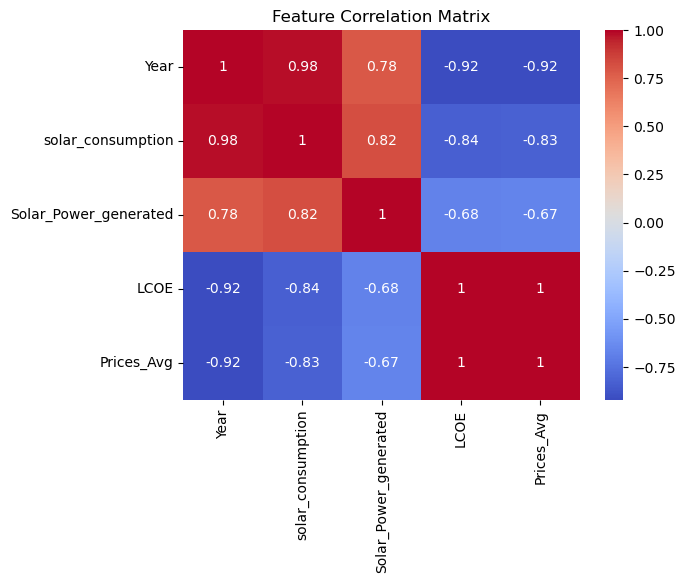

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check correlation matrix
corr_matrix = combined_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_df[['solar_consumption', 'Solar_Power_generated', 'LCOE']])
combined_df['consumption_power_interaction'] = combined_df['solar_consumption'] * combined_df['Solar_Power_generated']


### XGBoost and GradientBoosting

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_cv_scores = cross_val_score(gbm, X_scaled, y, cv=5, scoring='neg_mean_squared_error')

print("Gradient Boosting Average MSE:", -gbm_cv_scores.mean())


Gradient Boosting Average MSE: 111792.41599201396


In [42]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_cv_scores = cross_val_score(xgb, X_scaled, y, cv=5, scoring='neg_mean_squared_error')

print("XGBoost Average MSE:", -xgb_cv_scores.mean())


XGBoost Average MSE: 135732.6132472843


## Gradient Boosting

Best Params for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best MSE for Gradient Boosting after tuning: 249188.46862158598
Test MSE: 194420.03999788352


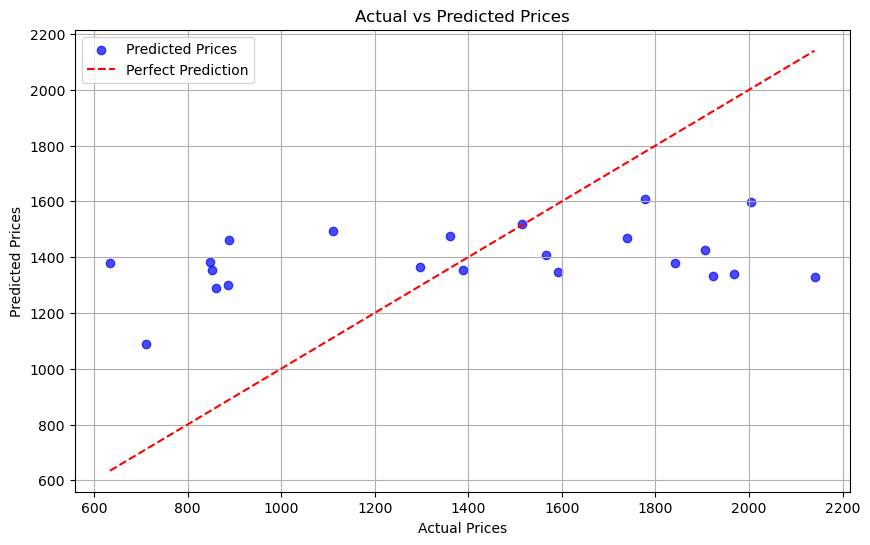

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

existing_data = pd.DataFrame({
    'Year': [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    'solar_consumption': [13.299, 17.683, 30.936, 57.336, 96.123, 121.960, 154.120, 178.734, 248.090],
    'Solar_Power_generated': [2821.91, 1171.62, 3130.36, 5658.63, 9563.69, 6750.97, 6510.06, 5628.80, 12760.50],
    'LCOE': [0.1323, 0.0866, 0.0817, 0.0746, 0.0541, 0.0428, 0.0406, 0.0367, 0.0374],
    'Prices_Avg': [2140, 1458, 1255, 1252, 889, 694, 661, 631, 640]
})

def generate_synthetic_data(existing_data, num_samples=100):
    synthetic_data = {
        'solar_consumption': [],
        'Solar_Power_generated': [],
        'LCOE': [],
        'Prices_Avg': []
    }

    for _ in range(num_samples):
        new_consumption = np.random.uniform(existing_data['solar_consumption'].min(), existing_data['solar_consumption'].max())
        new_power_generated = np.random.uniform(existing_data['Solar_Power_generated'].min(), existing_data['Solar_Power_generated'].max())
        new_lcoe = np.random.uniform(existing_data['LCOE'].min(), existing_data['LCOE'].max())
        new_prices_avg = np.random.uniform(existing_data['Prices_Avg'].min(), existing_data['Prices_Avg'].max())

        synthetic_data['solar_consumption'].append(new_consumption)
        synthetic_data['Solar_Power_generated'].append(new_power_generated)
        synthetic_data['LCOE'].append(new_lcoe)
        synthetic_data['Prices_Avg'].append(new_prices_avg)

    return pd.DataFrame(synthetic_data)

# Combine existing and synthetic data
synthetic_df = generate_synthetic_data(existing_data, num_samples=100)
combined_df = pd.concat([existing_data, synthetic_df], ignore_index=True)


X = combined_df[['solar_consumption', 'Solar_Power_generated', 'LCOE']]
y = combined_df['Prices_Avg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Tuning with Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_mse = -grid_search.best_score_
print("Best Params for Gradient Boosting:", best_params)
print("Best MSE for Gradient Boosting after tuning:", best_mse)

best_gb_model = GradientBoostingRegressor(**best_params, random_state=42)
best_gb_model.fit(X_train_scaled, y_train)

y_pred = best_gb_model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", test_mse)

# Plotting Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted Prices', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid()
plt.show()




## XGBoost

Best Params for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best MSE for XGBoost after tuning: 234149.7359528075
Test MSE: 191236.8244738905


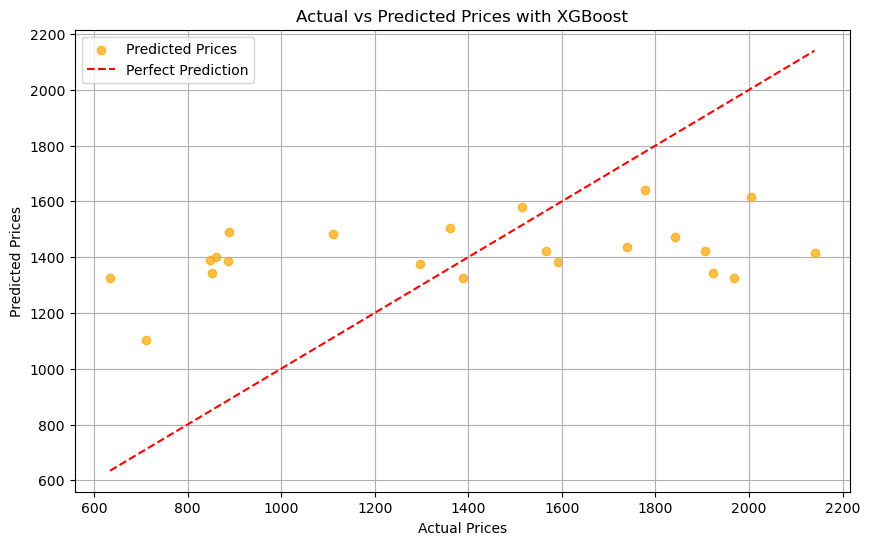

In [47]:
X = combined_df[['solar_consumption', 'Solar_Power_generated', 'LCOE']]
y = combined_df['Prices_Avg']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Tuning with XGBoost
xgb_model = XGBRegressor(random_state=42)
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]  # To prevent overfitting
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best parameters and MSE
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_
print("Best Params for XGBoost:", best_params)
print("Best MSE for XGBoost after tuning:", best_mse)

# Train the final model with the best parameters
best_xgb_model = XGBRegressor(**best_params, random_state=42)
best_xgb_model.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred = best_xgb_model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", test_mse)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='orange', label='Predicted Prices', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Prices with XGBoost')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid()
plt.show()

### THhis is for predicting usage using linear regression

Rows with missing or invalid Year values:
     Year  solar_consumption  Solar_Power_generated      LCOE   Prices_Avg
9     NaN         197.220849            6281.919591  0.101434  1012.490575
10    NaN          60.263860            4480.779265  0.054623  2003.516009
11    NaN          25.834174            6460.335134  0.064576  1906.636518
12    NaN          42.224509            4686.257917  0.059792  1777.158916
13    NaN         181.666984            5834.482379  0.110935  1804.734665
..    ...                ...                    ...       ...          ...
104   NaN         142.619529            6559.183611  0.100324  1079.066735
105   NaN         137.452985            6438.225171  0.109888  1369.228919
106   NaN         241.024178            9895.085719  0.048742  1533.258953
107   NaN         196.518124            2095.455598  0.099517  1387.738930
108   NaN          34.932709            9519.851150  0.089433  1584.104905

[100 rows x 5 columns]
Rows with missing Year values afte

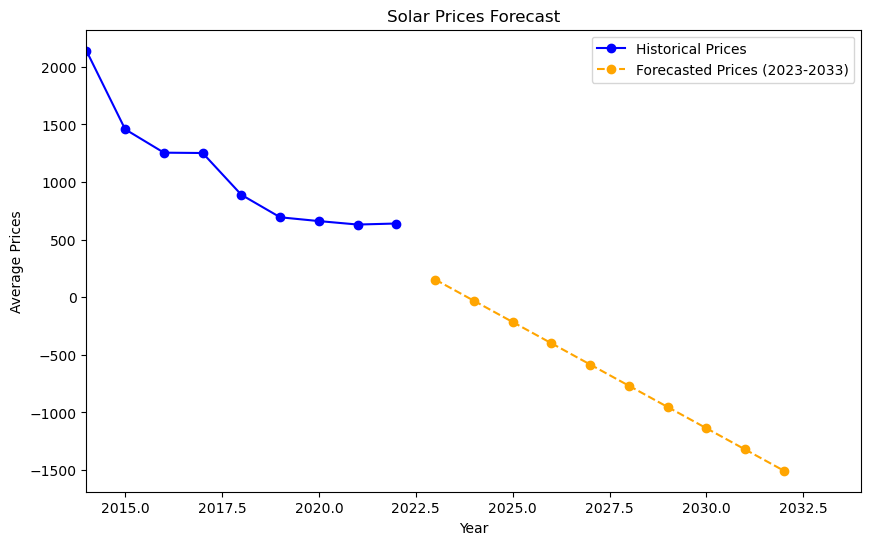

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


missing_years = combined_df[combined_df['Year'].isna()]
print("Rows with missing or invalid Year values:")
print(missing_years)
combined_df = combined_df.dropna(subset=['Year'])

combined_df['Year'] = pd.to_numeric(combined_df['Year'], errors='coerce')##check for missing values

missing_years_after = combined_df[combined_df['Year'].isna()]
print("Rows with missing Year values after cleaning:")
print(missing_years_after)

combined_df.reset_index(drop=True, inplace=True)
X = combined_df[['Year']] 
y = combined_df['Prices_Avg']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"\nLinear Regression Training Metrics:")
print(f"R²: {r2_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"MAE: {mae_train:.4f}")

print(f"\nLinear Regression Testing Metrics:")
print(f"R²: {r2_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"MAE: {mae_test:.4f}")

# Forecast for the next 10 years (2025-2034)
future_years = pd.DataFrame({'Year': np.arange(2023, 2033)})
future_predictions = model.predict(future_years)

# Create a DataFrame for the future predictions
future_df = pd.DataFrame(future_predictions, index=future_years['Year'], columns=['Forecasted Prices'])

# Step 4: Plotting the historical and forecasted prices
plt.figure(figsize=(10, 6))
plt.plot(combined_df['Year'], combined_df['Prices_Avg'], label='Historical Prices', color='blue', marker='o')
plt.plot(future_df.index, future_df['Forecasted Prices'], label='Forecasted Prices (2023-2033)', color='orange', linestyle='--', marker='o')

# Set x-axis limits from 2014 to 2034
plt.xlim([2014, 2034])
plt.xlabel('Year')
plt.ylabel('Average Prices')
plt.title('Solar Prices Forecast')
plt.legend()
plt.show()


In [50]:


# Display predicted values for training
train_predictions_df = pd.DataFrame({'Year': X_train['Year'], 'Actual Prices': y_train, 'Predicted Prices': y_train_pred})
train_predictions_df = train_predictions_df.sort_values(by='Year')
print("\nTraining Set Predictions:")
print(train_predictions_df)

# Display predicted values for the test set
test_predictions_df = pd.DataFrame({'Year': X_test['Year'], 'Actual Prices': y_test, 'Predicted Prices': y_test_pred})
test_predictions_df = test_predictions_df.sort_values(by='Year')
print("\nTest Set Predictions:")
print(test_predictions_df)

# Display forecasted values for future years
print("\nFuture Forecasted Prices (2023-2033):")
print(future_df)



Training Set Predictions:
     Year  Actual Prices  Predicted Prices
0  2014.0         2140.0       1813.571429
2  2016.0         1255.0       1444.714286
3  2017.0         1252.0       1260.285714
4  2018.0          889.0       1075.857143
5  2019.0          694.0        891.428571
6  2020.0          661.0        707.000000
8  2022.0          640.0        338.142857

Test Set Predictions:
     Year  Actual Prices  Predicted Prices
1  2015.0         1458.0       1629.142857
7  2021.0          631.0        522.571429

Future Forecasted Prices (2023-2033):
      Forecasted Prices
Year                   
2023         153.714286
2024         -30.714286
2025        -215.142857
2026        -399.571429
2027        -584.000000
2028        -768.428571
2029        -952.857143
2030       -1137.285714
2031       -1321.714286
2032       -1506.142857



XGBoost Training Metrics:
R²: 0.6510
MSE: 1963.9307
MAE: 33.5979

XGBoost Testing Metrics:
R²: 0.6481
MSE: 2281.7702
MAE: 47.7649


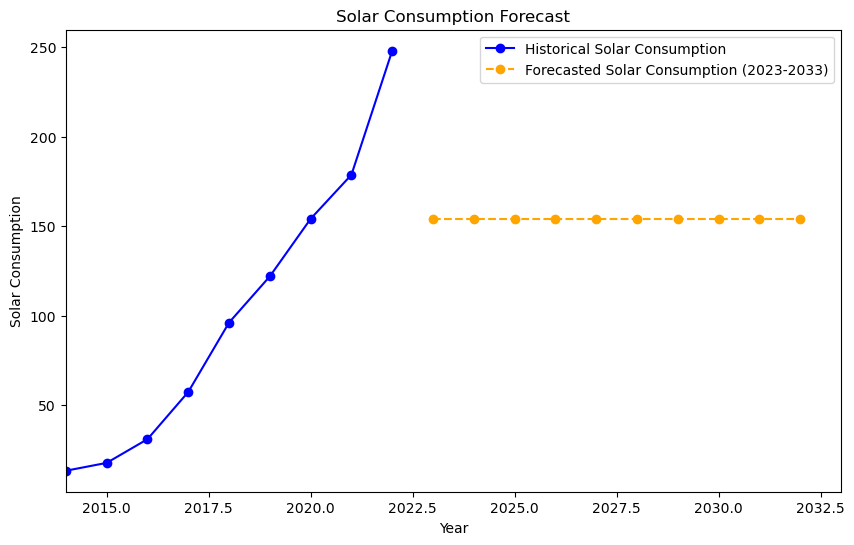

In [51]:

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

X = combined_df[['Year']]
y = combined_df['solar_consumption']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xg_model = XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8)
xg_model.fit(X_train, y_train)

# Predictions
y_pred_train = xg_model.predict(X_train)
y_pred_test = xg_model.predict(X_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"\nXGBoost Training Metrics:")
print(f"R²: {r2_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"MAE: {mae_train:.4f}")

print(f"\nXGBoost Testing Metrics:")
print(f"R²: {r2_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"MAE: {mae_test:.4f}")

# Forecasting future solar consumption
future_years = pd.DataFrame({'Year': np.arange(2023, 2033)})
future_predictions = xg_model.predict(future_years)
#Dataframe
future_df_xg = pd.DataFrame(future_predictions, index=future_years['Year'], columns=['Forecasted Solar Consumption'])

plt.figure(figsize=(10, 6))
plt.plot(combined_df['Year'], combined_df['solar_consumption'], label='Historical Solar Consumption', color='blue', marker='o')
plt.plot(future_df_xg.index, future_df_xg['Forecasted Solar Consumption'], label='Forecasted Solar Consumption (2023-2033)', color='orange', linestyle='--', marker='o')

plt.xlim([2014, 2033])
plt.xlabel('Year')
plt.ylabel('Solar Consumption')
plt.title('Solar Consumption Forecast')
plt.legend()
plt.show()


In [52]:

# Predicted values for the training set
train_predictions_df = pd.DataFrame({'Year': X_train['Year'], 'Actual Solar Consumption': y_train, 'Predicted Solar Consumption': y_pred_train})
train_predictions_df = train_predictions_df.sort_values(by='Year')

print("\nTraining Set Predictions:")
print(train_predictions_df)

# Predicted values for the test set
test_predictions_df = pd.DataFrame({'Year': X_test['Year'], 'Actual Solar Consumption': y_test, 'Predicted Solar Consumption': y_pred_test})
test_predictions_df = test_predictions_df.sort_values(by='Year')

print("\nTest Set Predictions:")
print(test_predictions_df)

# Display forecasted values for future years
print("\nFuture Forecasted Solar Consumption (2023-2033):")
print(future_df_xg)



Training Set Predictions:
     Year  Actual Solar Consumption  Predicted Solar Consumption
0  2014.0                    13.299                    65.981735
2  2016.0                    30.936                    66.840248
3  2017.0                    57.336                    73.673645
4  2018.0                    96.123                   102.535492
5  2019.0                   121.960                   114.585068
6  2020.0                   154.120                   131.502945
8  2022.0                   248.090                   154.233887

Test Set Predictions:
     Year  Actual Solar Consumption  Predicted Solar Consumption
1  2015.0                    17.683                    65.981735
7  2021.0                   178.734                   131.502945

Future Forecasted Solar Consumption (2023-2033):
      Forecasted Solar Consumption
Year                              
2023                    154.233887
2024                    154.233887
2025                    154.233887
2026      